### Table of Contents

* [Perceptron - sklearn](#Perceptron)
* [Tensorflow & Keras](#tensorflow_keras)
    * [Tensors](#tensors)
    * [Derivative computation](#tensors_derivatives)
* [Neural networks](#neural_networks)
    * [Layers in Keras](#keras_layers)
    * [Sequential Model - classification MLP](#sequential_api)
    * [Sequential Model - Regression MLP](#sequential_regression_mlp)
    * [Functional Model - Regression MLP](#functional_regression_mlp)
    * [Save & Load a model](#save_and_load)
    * [Callbacks & Tensorboard](#callbacks_and_tb)
    * [Multi input model](#multi_input_model)
    * [Multi input & output model](#multi_input_output_model)
    * [Subclassing API Wide & Deep](#subclass_api)
    * [Hyperparameters Search](#hyperparam_search)
    * [Batch Normalization](#batch_normalization)
    * [Gradient Clipping](#grad_clipping)
    * [transfer_learning](#transfer_learning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 

## Perceptron (sklearn)  <a class="anchor" id="Perceptron"></a>

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

/var/folders/yy/1_52rzrd2hl1hnsy89jp52zw0000gq/T/ipykernel_80274/454585095.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int)


In [3]:
y_pred

array([1])

# Tensorflow & Keras  <a class="anchor" id="tensorflow_keras"></a>

In [4]:
import tensorflow as tf
from tensorflow import keras


## Tensors & Variables  <a class="anchor" id="tensors"></a>
A tensor is the data flowing through the network 
Tensors are multi-dimensional arrays with a uniform type (like float/int/bool)


tf.constant generates a constant tensor which is immutable and cant be changed once defined

In [5]:
# using numpy array
a = tf.constant(np.array([2., 4., 5.]))
# using nested lists
u = tf.constant([[1],[2],[3]], dtype=tf.float32)
u

2023-01-22 11:34:56.086083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [6]:
tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)>

A variable is a special tensor which is mutable and can be updated during training 

In [7]:
V = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

# assignment
V.assign(2 * V) # => [[2., 4., 6.], [8., 10., 12.]]
V[0, 1].assign(42) # => [[2., 42., 6.], [8., 10., 12.]]
V[:, 2].assign([0., 1.]) # => [[2., 42., 0.], [8., 10., 1.]]
# indices is a list of entries specifications 
V.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.]) # => [[100., 42., 0.], [8., 10., 200.]]

# same as above using dtype for casting the values to float
V = tf.Variable([[1, 2, 3],[4, 5, 6]], shape=[2, 3], dtype=tf.float32)
V

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

tensorflow provides various operations to manipulate tensors using which the neural network is implemented

In [8]:
# Vu
x = tf.matmul(V, u, transpose_b=False)

# typing matters: this want work cant add int with float
# tf.constant(2.) + tf.constant(40)
tf.constant(2.) * tf.cast(tf.constant(40), tf.float32)


<tf.Tensor: shape=(), dtype=float32, numpy=80.0>

## Derivative computation <a class="anchor" id="tensors_derivatives"></a>

In [9]:
# to make the result reproducible 
tf.random.set_seed(10)

# the weights
W = tf.Variable(tf.random.normal((3, 2)), name='W')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]
y_true = [[5., 6.]]

# tf.GradientTape context will automatically record every operation that involves a variable, and finally we
# ask this tape to compute the gradients of the result loss with regards to both variables W and b

# The tape is automatically erased immediately after you call its gradient() method, so
# you will get an exception if you try to call gradient() twice, using persistent=True overrides this 
# and allows us to call gradient() multiple times
with tf.GradientTape(persistent=True) as tape:
    z = x @ W + b # the same as  y = tf.matmul(x, W) + b
    y = tf.sigmoid(z) # no really need for a sigmoid here, just for demonstration 
    loss = tf.reduce_mean((y_true - y)**2)

[dloss_dW, dloss_db] = tape.gradient(loss, [W, b])
[dloss_dW, dloss_db]

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-0.63425803, -0.31910765],
        [-1.2685161 , -0.6382153 ],
        [-1.9027741 , -0.95732296]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.63425803, -0.31910765], dtype=float32)>]

# Neural Networks  <a class="anchor" id="neural_networks"></a>

In [10]:
fashion_mnist = keras.datasets.fashion_mnist

class_names = [
    "T-shirt/top", 
    "Trouser", 
    "Pullover", 
    "Dress", 
    "Coat",
    "Sandal", 
    "Shirt", 
    "Sneaker", 
    "Bag", 
    "Ankle boot"
]

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(f'''
number of samplesin train: {X_train_full.shape[0]}
number of features: {X_train_full.shape}
''')


number of samplesin train: 60000
number of features: (60000, 28, 28)



In [11]:
# Scale features to be in the unit range [0,1]
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# don't forget scaling test too!!!
X_test = X_test / 255.


In [12]:
X_train[0].shape

(28, 28)

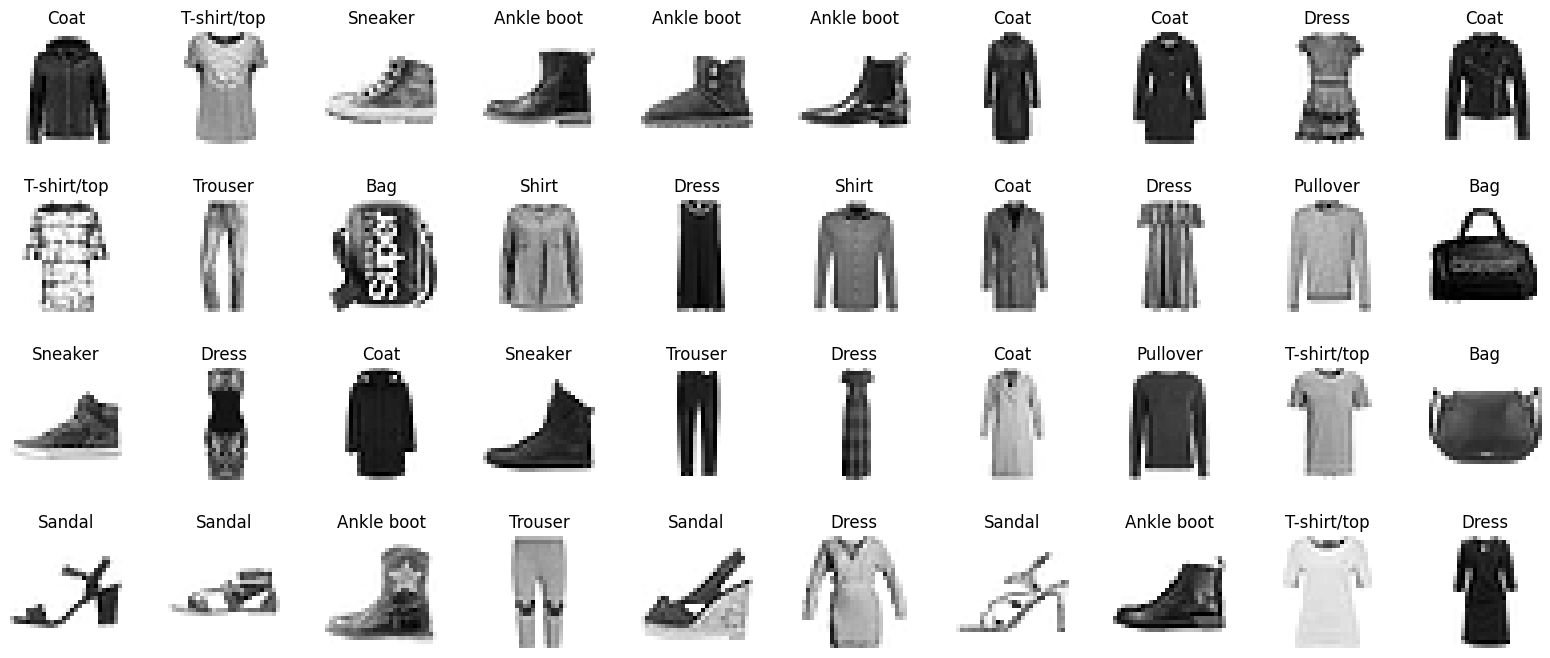

In [13]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 2, n_rows * 2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Layers in Keras  <a class="anchor" id="keras_layers"></a>

### Dense Layer

In [14]:
# units - the number of neurons in the layer 
# the number of input units is either determined in runtime (first call) or by declaring input size (see below)
dense_layer = keras.layers.Dense(units=4, 
                                 activation='sigmoid', 
                                 use_bias=True, 
                                 kernel_initializer='glorot_normal', 
                                 name='my_dense_layer')

input_batch = tf.constant([[1.,2.,3.],[0.,1.,2.]])

dense_layer(input_batch)


<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.83527493, 0.13449433, 0.19688019, 0.01715243],
       [0.7575792 , 0.38422322, 0.50228566, 0.08236018]], dtype=float32)>

In [15]:
# this will raise an error
different_input_batch = tf.constant([[1.,2.],[0.,1.]])
dense_layer(different_input_batch)


ValueError: Input 0 of layer "my_dense_layer" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (2, 2)

In [ ]:
# get the weights :  #input neurons x #units   and the bias weights: # units
# notece that these are Variables 
dense_layer.weights

### Embedding layer
Transforms a categorical variable to a vector.

Equivalent to transforming the index to a one-hot vector and then multiplying by an embedding matrix 

[The, dog, eats] -> [2, 30, 15] -> Embedding layer -> vectors

In [ ]:
# input dim is the vocabulary size: vocabulary size is taken to be 100
# vector size is 4 (embedding size)

indexed_values = tf.constant([[1,2,3],[0,1,2]])
embedding_layer = keras.layers.Embedding(input_dim=100, output_dim=4, mask_zero=True)
embedding_layer(indexed_values)

In [ ]:
# calculates the vectors to be discarded
embedding_layer.compute_mask(indexed_values)

## Sequential Model - Classification <a class="anchor" id="sequential_api"></a>

In [16]:
# Resets all state generated by Keras. (responsible for managing layer names etc.)
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)


# sequential API
model = keras.models.Sequential()
# flattens tensor shape (28,28) to (784,)
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", name='my_hidden'))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Equivalent 
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [17]:
# show the layers of the model
model.layers

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 my_hidden (Dense)           (None, 300)               235500    
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [19]:
# %pip install pydot

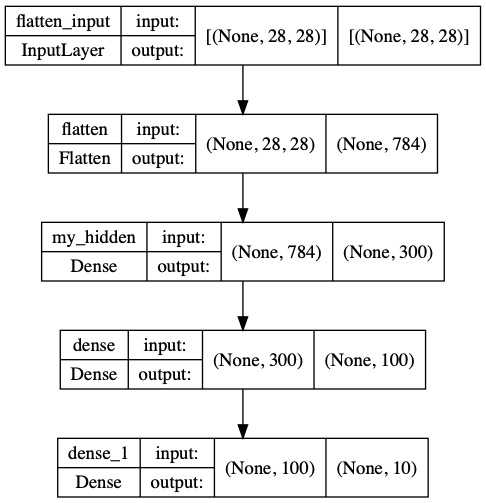

In [20]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
# get the first hidden layer
hidden1 = model.layers[1]
# its name
layer_name = hidden1.name
# can access a layer by name
hidden1 = model.get_layer('my_hidden')

# get the layer weights
weights, biases = hidden1.get_weights()

print(f'''
hidden layer 1 name: {layer_name}
weights shape: {weights.shape}
bias shape: {biases.shape}
''')


hidden layer 1 name: my_hidden
weights shape: (784, 300)
bias shape: (300,)



Compilation - binds a loss and an optimizer to the model

In [23]:
# compile the model - Configures the model for training.
# categorical crossentropy in the exact same loss as softmax classification model
# metrics: List of metrics to be evaluated by the model during training and testing.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# equivalent
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=[keras.metrics.sparse_categorical_accuracy])

In [24]:
# Note: we can also provide validation data 
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4844 - accuracy: 0.8316 - val_loss: 0.4350 - val_accuracy: 0.8532
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4393 - accuracy: 0.8453 - val_loss: 0.5318 - val_accuracy: 0.7976
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4125 - accuracy: 0.8567 - val_loss: 0.3916 - val_accuracy: 0.8644
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3940 - accuracy: 0.8619 - val_loss: 0.3749 - val_accuracy: 0.8688
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3753 - accuracy: 0.8677 - val_loss: 0.3714 - val_accuracy: 0.8728
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3634 - accuracy: 0.8714 - val_loss: 0.3615 - val_accuracy:

In [25]:
# show training params like numbber of epochs ran 
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1719}

In [26]:
# metrics
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epoch'})[:5]

,epoch,loss,accuracy,val_loss,val_accuracy
0,0,0.723678,0.764418,0.520675,0.8234
1,1,0.484357,0.831636,0.435026,0.8532
2,2,0.439301,0.845345,0.531794,0.7976
3,3,0.412508,0.856691,0.391630,0.8644
4,4,0.394011,0.861891,0.374887,0.8688


(0.0, 1.0)

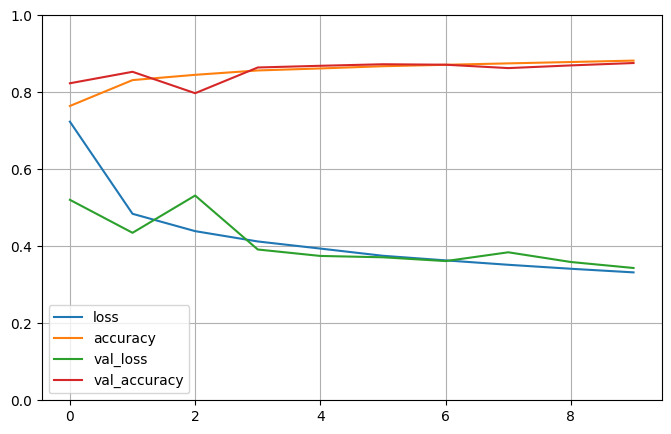

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [29]:
# evaluate on test
# loss and metric results are returned as a dict, with each key being the name of the metric
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

313/313 [==============================] - 0s 1ms/step - loss: 0.3797 - accuracy: 0.8612


(0.37966325879096985, 0.8611999750137329)

In [30]:
# predict
X_new = X_test[:10]
y_proba = model.predict(X_new)

print(f'''
raw predictions: 
{y_proba.round(2)}
predicted classes 
{np.array(class_names)[np.argmax(model.predict(X_new), axis=-1)]}
''')



raw predictions: 
[[0.   0.   0.   0.   0.   0.12 0.   0.05 0.   0.83]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.19 0.   0.08 0.   0.01 0.   0.72 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.02 0.   0.86 0.   0.11 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.1  0.   0.88 0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.92 0.01 0.04 0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.99 0.   0.  ]]
predicted classes 
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']



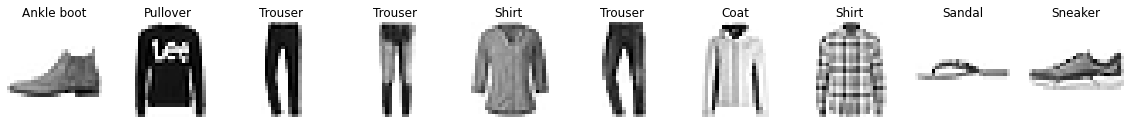

In [39]:
plt.figure(figsize=(20, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, len(X_new), index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)


## Sequential API - Regression MLP  <a class="anchor" id="sequential_regression_mlp"></a>

In [31]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# information about the data
print(housing['DESCR'])

print('Data table')
print('===========')
print(fetch_california_housing(as_frame=True)['data'].head())

# target/label = MedHouseVal

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# features scaling
scaler = StandardScaler()

# fit only on train
X_train = scaler.fit_transform(X_train)

# transform validation and test
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

# reset the state - all previous variables are deleted from memory
keras.backend.clear_session()

# Define the model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print(f'MSE on test {mse_test}')

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - val_loss: 0.4656

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


(0.0, 1.0)

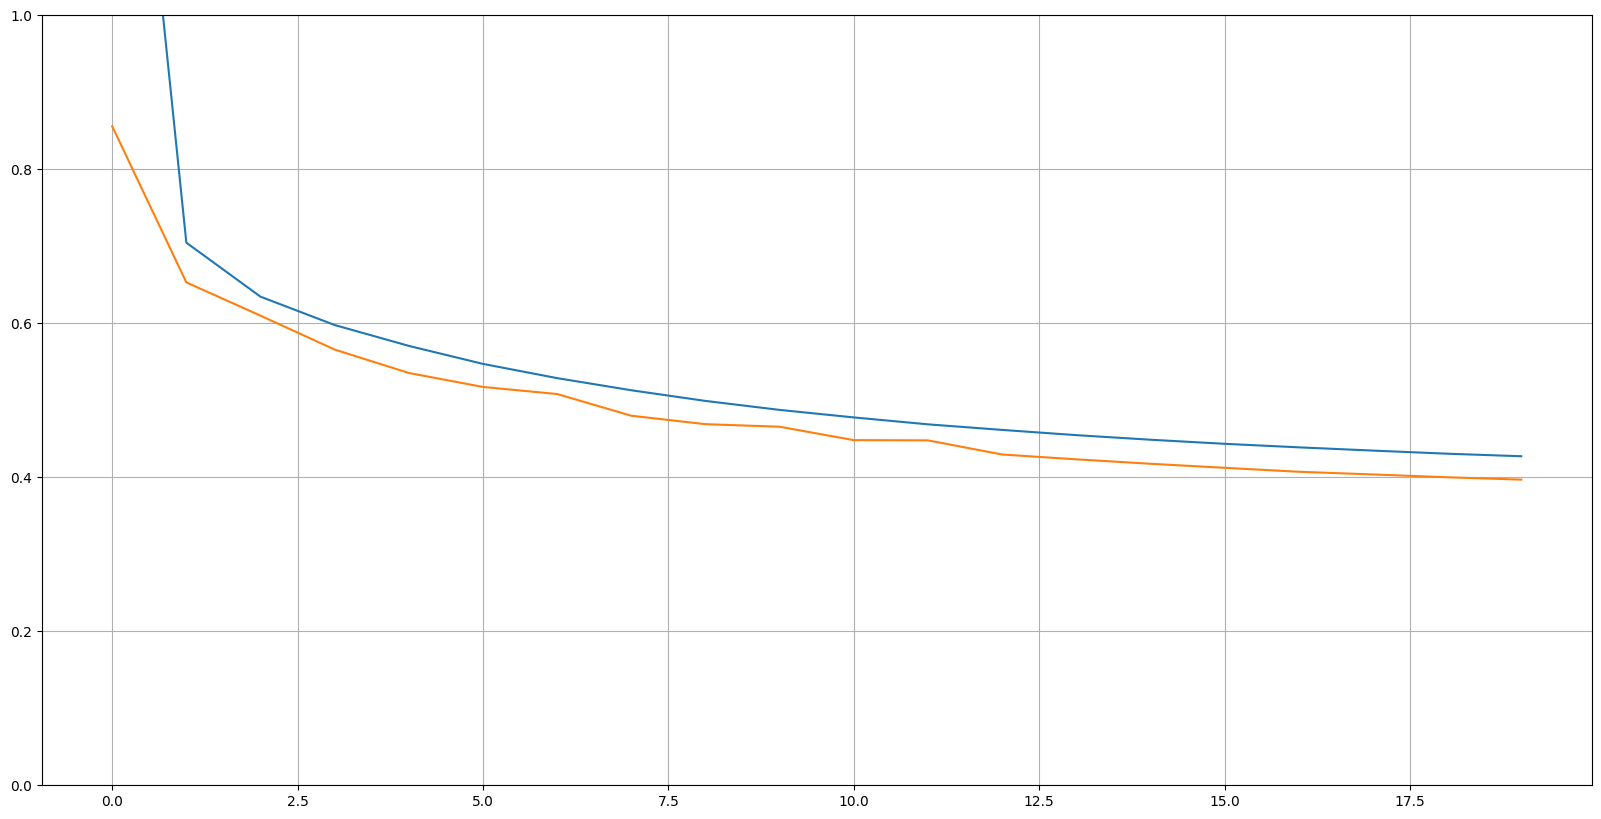

In [34]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)

## Functional API - Regression MLP  <a class="anchor" id="functional_regression_mlp"></a>

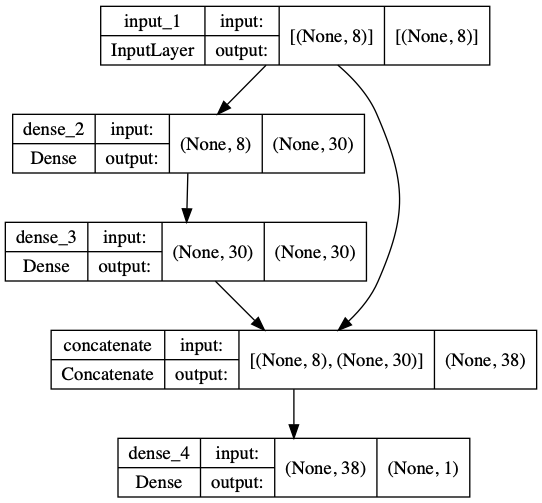

In [36]:
## Functional API
# Allows to define more complex networks 
# The following architecture is called "wide and deep" 
# “Wide & Deep Learning for Recommender Systems,” Heng-Tze Cheng et al. (2016).


np.random.seed(42)
tf.random.set_seed(42)

# Here the input shape is (8,) we are not taking the first dimension (the dataset size)
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
# this layer just concatenates the input_ tensor and hidden2 tensor along the last axis
concat = keras.layers.concatenate([input_, hidden2], axis=-1)
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_], outputs=[output])

keras.utils.plot_model(model, show_shapes=True)

In [37]:
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
print(f'MSE on test {mse_test}')

y_pred = model.predict(X_new)


Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4659 - val_loss: 0.4313

## Saving and loading <a class="anchor" id="save_and_load"></a>

In [38]:
# save and load model
model.save("my_keras_model.h5", include_optimizer=True)
model = keras.models.load_model("my_keras_model.h5")
y_pred = model.predict(X_new)



In [39]:
# only saves the weights the network will need to be defined via code
model.save_weights("my_keras_weights.ckpt")

# define the model here
# ....
# ....
model.load_weights("my_keras_weights.ckpt")



## Using callbacks & Tensorboard <a class="anchor" id="callbacks_and_tb"></a>


In [ ]:
# To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

# $ tensorboard --logdir=./my_logs --port=6006
# You can then open your web browser to localhost:6006 and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006


In [42]:
import os


# checkpoint a model. here we save the best model relative to validation loss
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="my_keras_model_ckpt.h5",     
                                                monitor='val_loss',
                                                save_best_only=True)

# restore_best_weights - Whether to restore model weights from
# the epoch with the best value of the monitored quantity.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# custom callback
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

history = model.fit(
    X_train, y_train, 
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, 
               early_stopping_cb,
               PrintValTrainRatioCallback(),
               keras.callbacks.TensorBoard(run_logdir)]
)



Epoch 1/10
324/363 [=========================>....] - ETA: 0s - loss: 0.4045
val/train: 0.93
363/363 [==============================] - 1s 2ms/step - loss: 0.4053 - val_loss: 0.3761
Epoch 2/10
360/363 [============================>.] - ETA: 0s - loss: 0.4023
val/train: 0.98
363/363 [==============================] - 1s 2ms/step - loss: 0.4021 - val_loss: 0.3929
Epoch 3/10
342/363 [===========================>..] - ETA: 0s - loss: 0.4021
val/train: 0.94
363/363 [==============================] - 1s 2ms/step - loss: 0.3994 - val_loss: 0.3735
Epoch 4/10
353/363 [============================>.] - ETA: 0s - loss: 0.3965
val/train: 0.94
363/363 [==============================] - 1s 2ms/step - loss: 0.3963 - val_loss: 0.3707
Epoch 5/10
344/363 [===========================>..] - ETA: 0s - loss: 0.3898
val/train: 0.94
363/363 [==============================] - 1s 2ms/step - loss: 0.3941 - val_loss: 0.3687
Epoch 6/10
341/363 [===========================>..] - ETA: 0s - loss: 0.3899
val/train: 0.

## Multi Input model <a class="anchor" id="multi_input_model"></a>

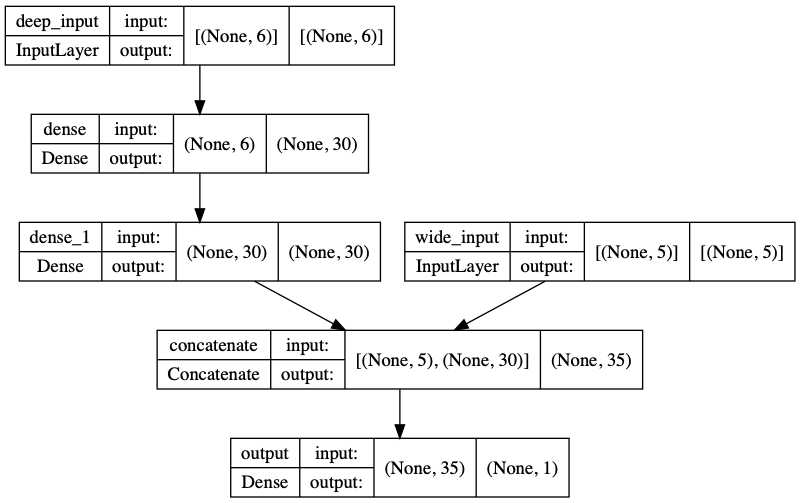

In [46]:
# Splitting the input - for multiple inputs model
keras.backend.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=(5,), name="wide_input")

input_B = keras.layers.Input(shape=(6,), name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)

# define the model by specifying the inputs and output tensors 
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

keras.utils.plot_model(model, show_shapes=True)

In [47]:
X_train.shape

(11610, 8)

In [48]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

# Generate the data - split the features 

# X_train_A - fetaure 0-4 (5)
# X_train_B - feature 2-8 (6)
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# fit
history = model.fit(x=(X_train_A, X_train_B), 
                    y=y_train, 
                    epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid)
                   )
# evaluate on test
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
# make a prediction
y_pred = model.predict((X_new_A, X_new_B))


Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4644 - val_loss: 0.4315

## Multi Input Multi output Model <a class="anchor" id="multi_input_output_model"></a>

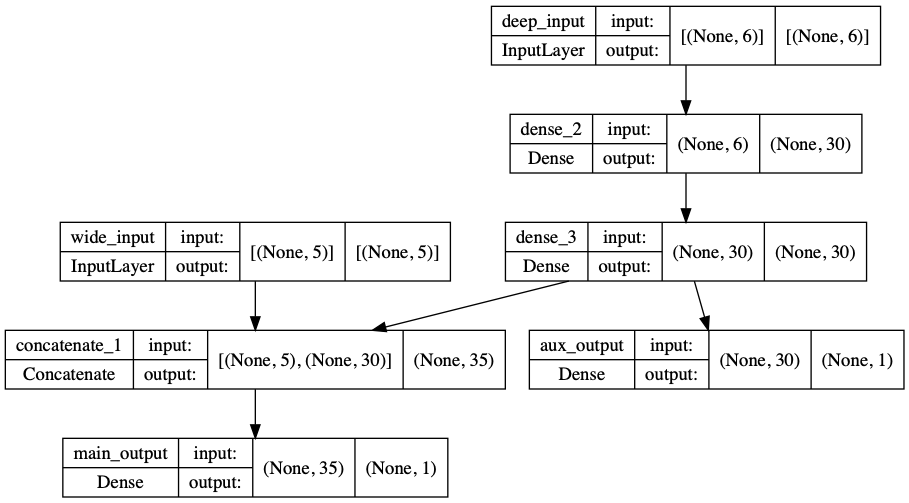

In [49]:

input_A = keras.layers.Input(shape=(5,), name="wide_input")

input_B = keras.layers.Input(shape=(6,), name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)

aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

# for each of the outputs tensors a loss is specified and a weight for aggregating the losses 
model.compile(loss={'main_output': "mse", 'aux_output':"mse"}, 
              loss_weights={'main_output': 0.9, 'aux_output':0.1}, 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

keras.utils.plot_model(model, show_shapes=True)

In [50]:
history = model.fit(x=[X_train_A, X_train_B], 
                    y=[y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

# we see that the lower the weight the bigger the loss - as it is less influential on the final loss

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0984 - main_output_loss: 1.8521 - aux_output_loss: 4.3151 - val_loss: 1.5430 - val_main_output_loss: 0.9144 - val_aux_output_loss: 7.2005
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9781 - main_output_loss: 0.7778 - aux_output_loss: 2.7815 - val_loss: 1.3118 - val_main_output_loss: 0.6824 - val_aux_output_loss: 6.9755
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8065 - main_output_loss: 0.6685 - aux_output_loss: 2.0489 - val_loss: 1.2622 - val_main_output_loss: 0.6458 - val_aux_output_loss: 6.8096
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7198 - main_output_loss: 0.6114 - aux_output_loss: 1.6951 - val_loss: 1.2022 - val_main_output_loss: 0.6136 - val_aux_output_loss: 6.5002
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6700 - main_output_loss: 0.5756 - aux_output_loss: 1.5195 - val_loss

In [52]:
total_loss, main_loss, aux_loss = model.evaluate(
    x=[X_test_A, X_test_B], 
    y=[y_test, y_test]
)

print(f'metrics: {model.metrics_names}')

print(f"""
main loss {main_loss}
aux loss {aux_loss}
total loss {total_loss}
""")
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])


162/162 [==============================] - 0s 1ms/step - loss: 0.4822 - main_output_loss: 0.4278 - aux_output_loss: 0.9714
metrics: ['loss', 'main_output_loss', 'aux_output_loss']

main loss 0.42779430747032166
aux loss 0.9713802933692932
total loss 0.48215290904045105



## The subclassing API <a class="anchor" id="subclass_api"></a>

In [55]:
keras.backend.clear_session()


# define the model as a derived class of Model class
class WideAndDeepModel(keras.models.Model):
    
    def __init__(self, units=30, activation="relu", **kwargs):
    
        super().__init__(**kwargs)
        # all layers are declared in the constructor
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        # forward pass 
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

# need to be buit before summary is available
model.build(input_shape=[(None, 5), (None, 6)])
model.summary()

# plot_model does not work out of the box :)
# inputs = [keras.layers.Input(shape=(None,8)),keras.layers.Input(shape=(None,8))]
# model = keras.models.Model(inputs=inputs,outputs=model.call(inputs))
# keras.utils.plot_model(model, show_shapes=True)


Model: "wide_and_deep_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  210       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  36        
                                                                 
 dense_3 (Dense)             multiple                  31        
                                                                 
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss="mse", 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )
history = model.fit(x=(X_train_A, X_train_B), 
                    y=(y_train, y_train), 
                    epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))


Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.6381 - output_1_loss: 2.4121 - output_2_loss: 4.6721 - val_loss: 3.1302 - val_output_1_loss: 2.9690 - val_output_2_loss: 4.5812
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.0823 - output_1_loss: 0.8798 - output_2_loss: 2.9045 - val_loss: 1.4616 - val_output_1_loss: 1.1332 - val_output_2_loss: 4.4175
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.8666 - output_1_loss: 0.7355 - output_2_loss: 2.0466 - val_loss: 1.0709 - val_output_1_loss: 0.7464 - val_output_2_loss: 3.9914
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7706 - output_1_loss: 0.6684 - output_2_loss: 1.6905 - val_loss: 0.9311 - val_output_1_loss: 0.6336 - val_output_2_loss: 3.6091
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7146 - output_1_loss: 0.6243 - output_2_loss: 1.5274 - val_loss: 0.8453 - val_output_1_loss: 0.5773 - val_ou

## Hyperparameters search using scikit learn API <a class="anchor" id="hyperparam_search"></a>
a wrapper Scikit-Learn API

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)

# for classifier 
# keras_cls = keras.wrappers.scikit_learn.KerasClassifier(build_model)

keras_reg.fit(X_train, y_train, epochs=10,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

mse_test = keras_reg.score(X_test, y_test)


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

# specify the search domain
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(), # sampling from A loguniform
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X=X_train, y=y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

print(f'''
best params: {rnd_search_cv.best_params_}
best score: {rnd_search_cv.best_score_}
''')

# KerasRegressor
rnd_search_cv.best_estimator_

best_model = model = rnd_search_cv.best_estimator_.model


In [ ]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# standardizing per pixel 
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Batch Normalization <a class="anchor" id="batch_normalization"></a>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation="softmax")
])
model.summary()


# Using before activations - note that now we define the activation outside 
# of the layer definition we also don't use bias, since it is learned by the bias
# parameter of the BN layer

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(300, use_bias=False),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation("relu"),
#     keras.layers.Dense(100, use_bias=False),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation("relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

## Gradient clipping  <a class="anchor" id="grad_clipping"></a>

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
optimizer = keras.optimizers.SGD(clipnorm=1.0)


## Transfer learning  <a class="anchor" id="transfer_learning"></a>

In [ ]:

model_A = keras.models.load_model("my_model_A.h5")

# if we won't clone model A, its weights will be updated with modelB_on_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")
                 
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# You must always compile your model after you freeze or unfreeze layers.
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])